In [4]:
import re
import math
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.linear_model import Ridge, RidgeClassifier, RidgeClassifierCV, PassiveAggressiveClassifier, PassiveAggressiveRegressor, LinearRegression, HuberRegressor
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

In [5]:
def add_squared_col(X):
    return np.hstack((X, X**2))
marker = ['^','<','>','*','D','P']

In [6]:
col_types = {'Age': np.int32, 'Potential': np.int32, 'Overall': np.int32}
ff18 = pd.read_csv('data/CompleteDataset.csv', usecols=['Name', 'Nationality', 'Club', 'Photo', 'Value', 'Age', 'Wage', 'Potential', 'Overall', 'Finishing', 'Penalties', 'Aggression', 'Crossing', 'Stamina', 'Dribbling'], dtype=col_types)

In [7]:
def finishing(s):
    try:
        n = int(s)
        return (1 <= n and n <= 99)
    except:
        return False

In [8]:
cols_int = ['Age', 'Potential', 'Finishing', 'Penalties', 'Aggression', 'Crossing', 'Stamina', 'Dribbling']
for col in cols_int:
    ff18 = ff18.loc[ff18[col].apply(lambda x: finishing(x))]
    ff18[col] = ff18[col].astype('int')

In [9]:
ff18.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17192 entries, 0 to 17416
Data columns (total 15 columns):
Name           17192 non-null object
Age            17192 non-null int64
Photo          17192 non-null object
Nationality    17192 non-null object
Overall        17192 non-null int32
Potential      17192 non-null int64
Club           16953 non-null object
Value          17192 non-null object
Wage           17192 non-null object
Aggression     17192 non-null int64
Crossing       17192 non-null int64
Dribbling      17192 non-null int64
Finishing      17192 non-null int64
Penalties      17192 non-null int64
Stamina        17192 non-null int64
dtypes: int32(1), int64(8), object(6)
memory usage: 2.0+ MB


In [10]:
def str2number(amount):
    if amount[-1] == 'M':
        amount = float(re.sub('[^\d\.]', '', amount))
        return float(amount)*1000000
    elif amount[-1] == 'K':
        amount = float(re.sub('[^\d\.]', '', amount))
        return float(amount)*1000
    else:
        amount = float(re.sub('[^\d\.]', '', amount))
        return float(amount)
ff18['ValueNum'] = ff18['Value'].apply(lambda x: str2number(x))

In [11]:
ff18.head(1).T

,0
Name,L. Messi
Age,30
Photo,https://cdn.sofifa.org/sm/18/players/158023.png
Nationality,Argentina
Overall,94
Potential,94
Club,FC Barcelona
Value,€118.5M
Wage,€565K
Aggression,48


In [12]:
ff18.describe()

,Age,Overall,Potential,Aggression,Crossing,Dribbling,Finishing,Penalties,Stamina,ValueNum
count,17192.000000,17192.000000,17192.000000,17192.000000,17192.000000,17192.000000,17192.000000,17192.000000,17192.000000,1.719200e+04
mean,24.900128,66.722429,71.458527,56.391985,50.344172,55.674965,45.817939,49.062122,63.821429,2.384042e+06
std,4.615540,6.298350,5.880039,17.353942,18.243702,18.742092,19.402826,15.685451,15.501422,5.460780e+06
min,16.000000,53.000000,53.000000,11.000000,5.000000,4.000000,2.000000,5.000000,13.000000,0.000000e+00
25%,21.000000,62.000000,67.000000,44.000000,39.000000,49.000000,30.000000,39.000000,58.000000,3.500000e+05
50%,25.000000,67.000000,71.000000,59.000000,55.000000,61.000000,49.000000,50.000000,67.000000,7.250000e+05
75%,28.000000,71.000000,75.000000,70.000000,64.000000,68.000000,62.000000,61.000000,74.000000,2.100000e+06
max,44.000000,94.000000,94.000000,96.000000,92.000000,97.000000,95.000000,92.000000,95.000000,1.195000e+08


In [13]:
ff18.Overall.describe()

count    17192.000000
mean        66.722429
std          6.298350
min         53.000000
25%         62.000000
50%         67.000000
75%         71.000000
max         94.000000
Name: Overall, dtype: float64

In [14]:
ff18 = ff18.loc[ff18.ValueNum > 0]

In [15]:
ff18.head(5)

,Name,Age,Photo,Nationality,Overall,Potential,Club,Value,Wage,Aggression,Crossing,Dribbling,Finishing,Penalties,Stamina,ValueNum
0,L. Messi,30,https://cdn.sofifa.org/sm/18/players/158023.png,Argentina,94,94,FC Barcelona,€118.5M,€565K,48,77,97,95,75,73,118500000.0
1,Cristiano Ronaldo,32,https://cdn.sofifa.org/sm/18/players/20801.png,Portugal,94,94,Real Madrid CF,€95.5M,€565K,63,85,91,94,85,92,95500000.0
2,Neymar,25,https://cdn.sofifa.org/sm/18/players/190871.png,Brazil,92,93,Paris Saint-Germain,€119.5M,€280K,56,75,96,88,81,78,119500000.0
3,L. Suárez,30,https://cdn.sofifa.org/sm/18/players/176580.png,Uruguay,92,92,FC Barcelona,€97M,€510K,87,77,86,94,85,89,97000000.0
4,M. Neuer,31,https://cdn.sofifa.org/sm/18/players/167495.png,Germany,92,92,FC Bayern Munich,€61M,€230K,29,15,30,13,47,43,61000000.0


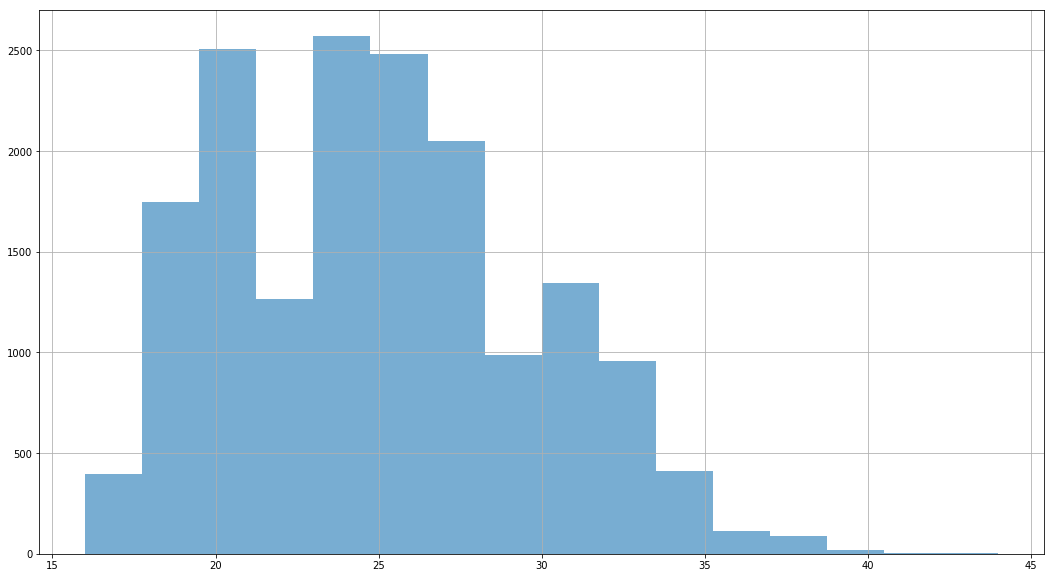

In [16]:
plt.figure(figsize=(18, 10))
plt.grid(True)
ff18.Age.hist(bins=16, alpha=.6)
plt.show()

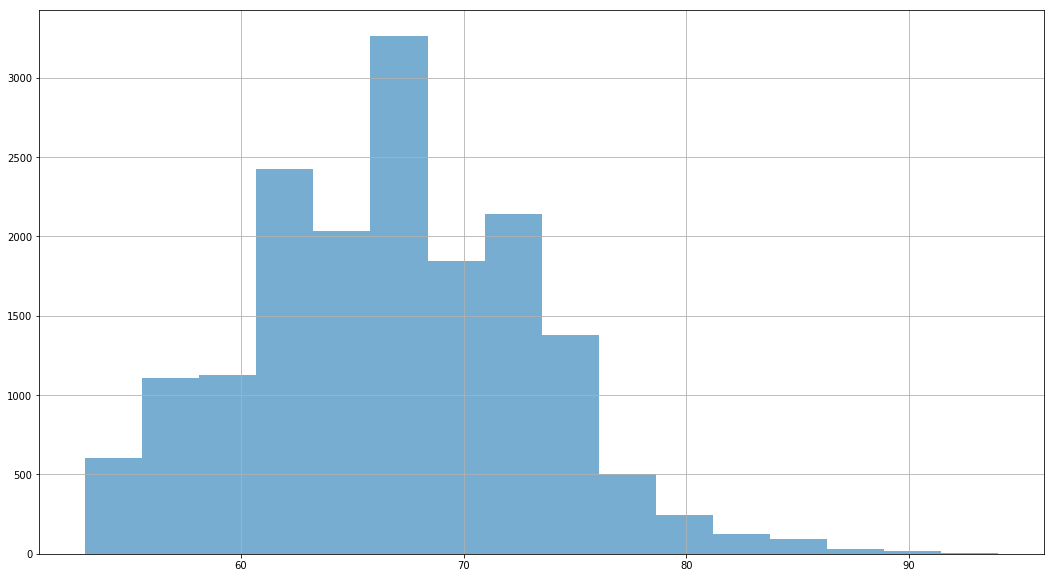

In [17]:
plt.figure(figsize=(18, 10))
ff18.Overall.hist(bins=16, alpha=.6)
plt.grid(True)
plt.show()

In [18]:
# ff18.fillna(value=-99999, inplace=True)
# forecast_col = 'Overall'
# forecast_out = int(math.ceil(0.01 * len(ff18)))
# ff18['label'] = ff18[forecast_col].shift(-forecast_out)

In [19]:
# building our predictive model
train, test = train_test_split(ff18, test_size=0.4, random_state=45)

xtrain = train[['ValueNum', 'Age', 'Finishing', 'Aggression', 'Crossing', 'Stamina', 'Dribbling']]
ytrain = train[['Overall']]
xtest = test[['ValueNum', 'Age', 'Finishing', 'Aggression', 'Crossing', 'Stamina', 'Dribbling']]
ytest = test[['Overall']]

In [20]:
print("Players less than 30 Million Euro {:.2f}%".format(test.loc[test.ValueNum <= 30000000].ValueNum.count().astype('float') / test.ValueNum.count().astype('float') * 100))

Players less than 30 Million Euro 99.23%


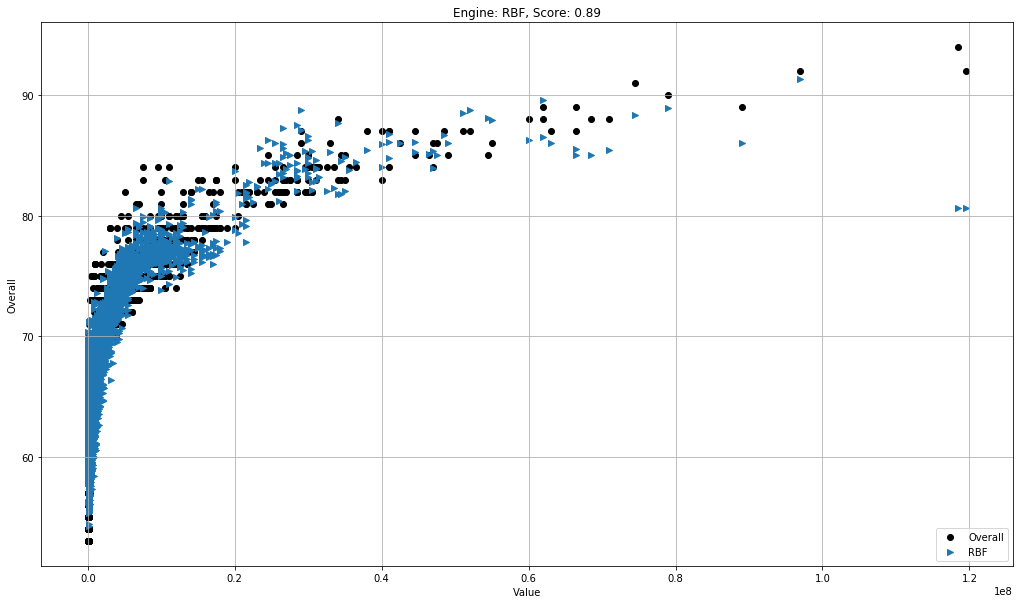

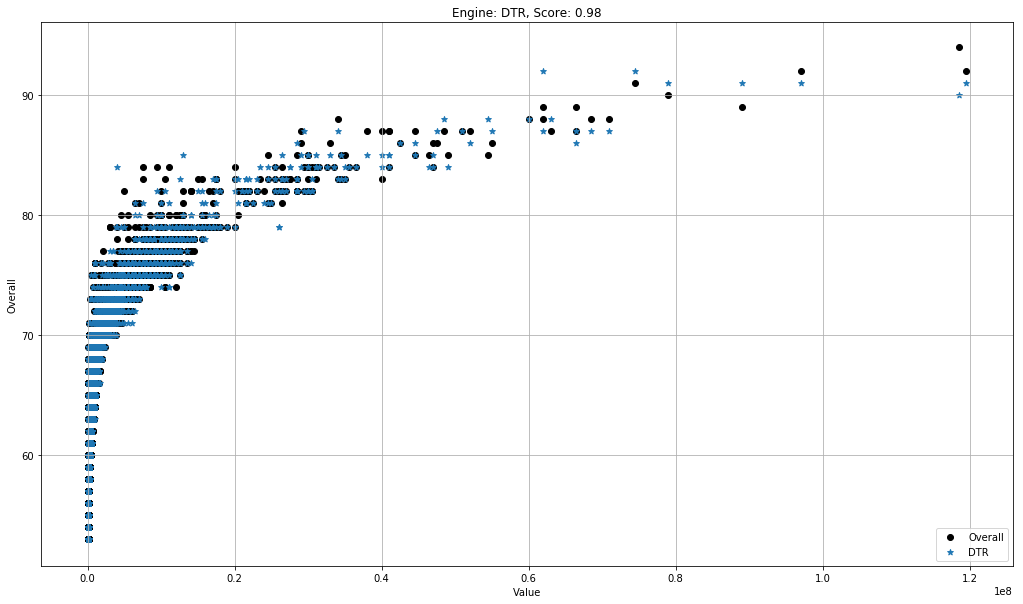

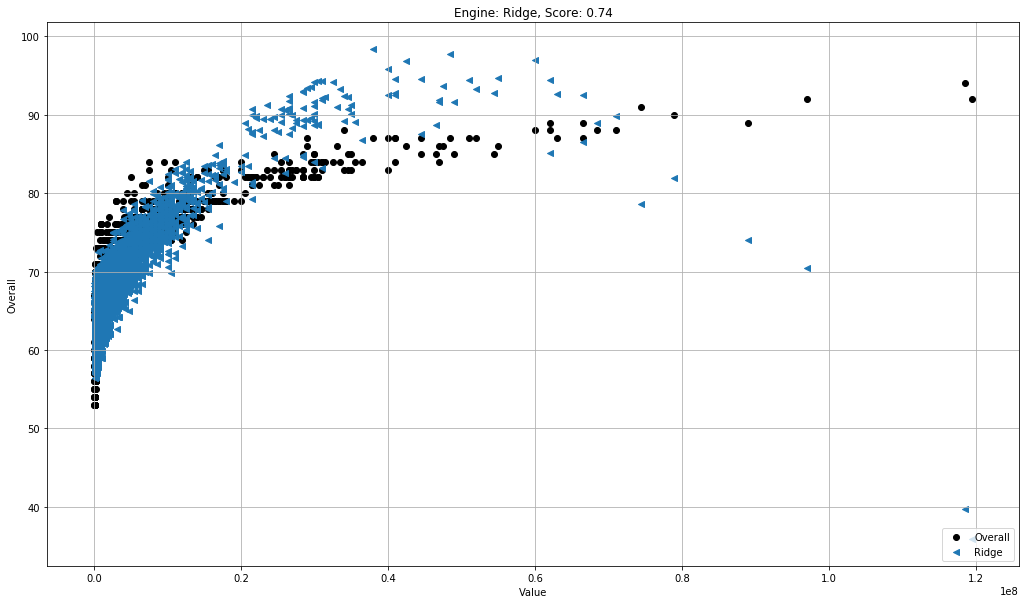

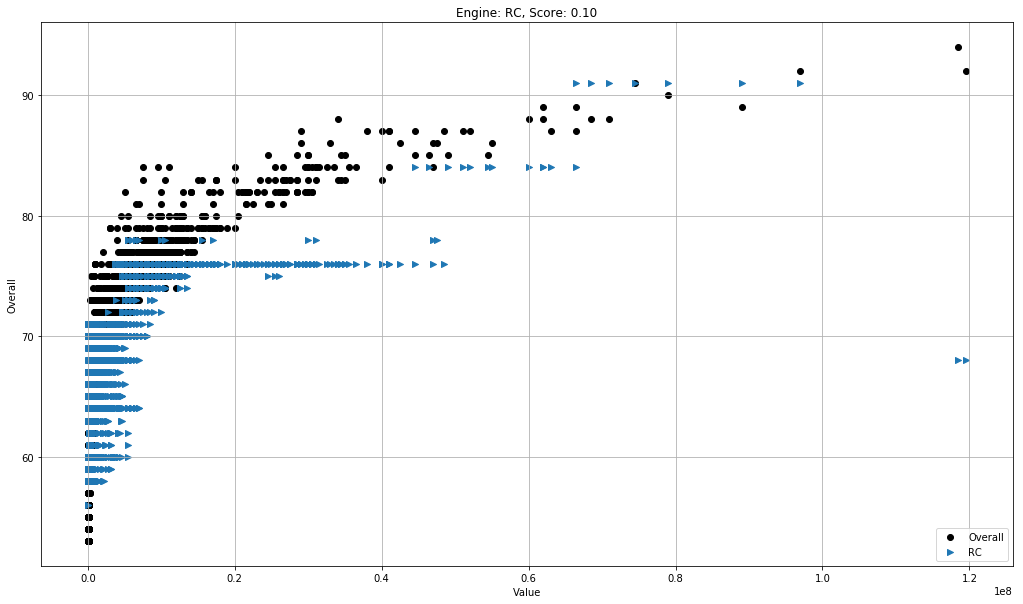

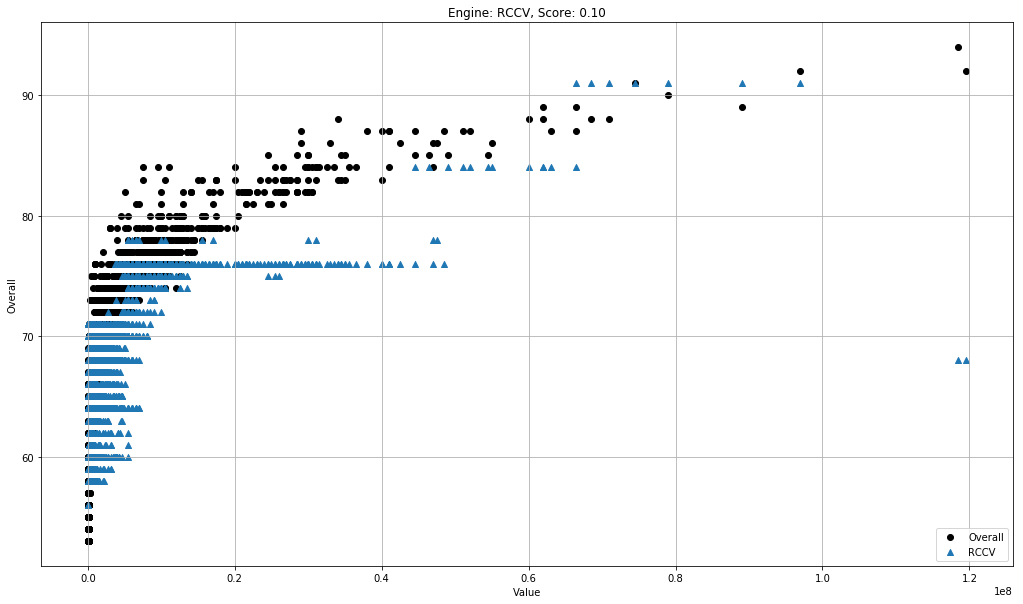

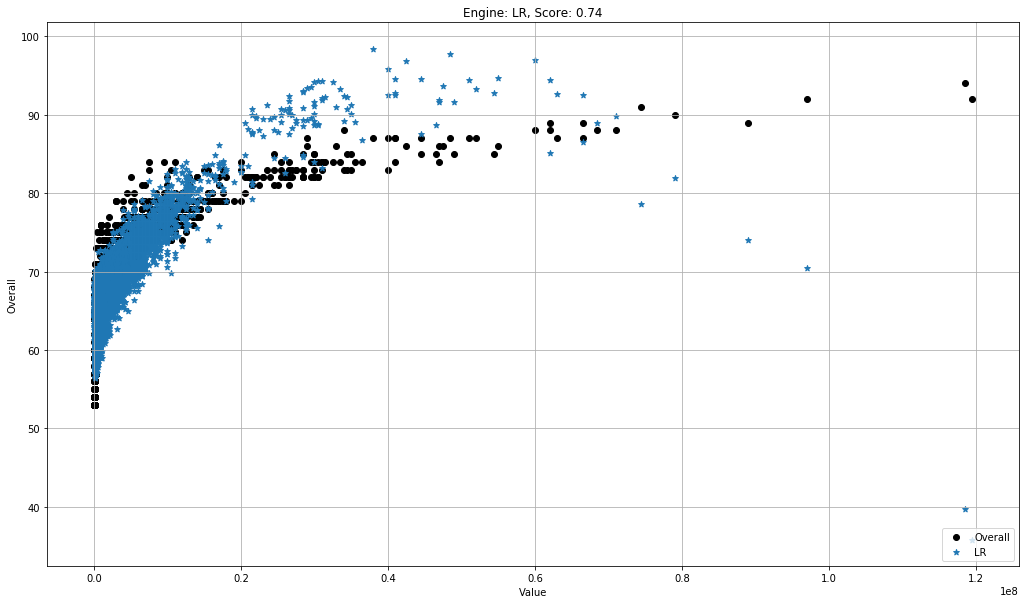

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


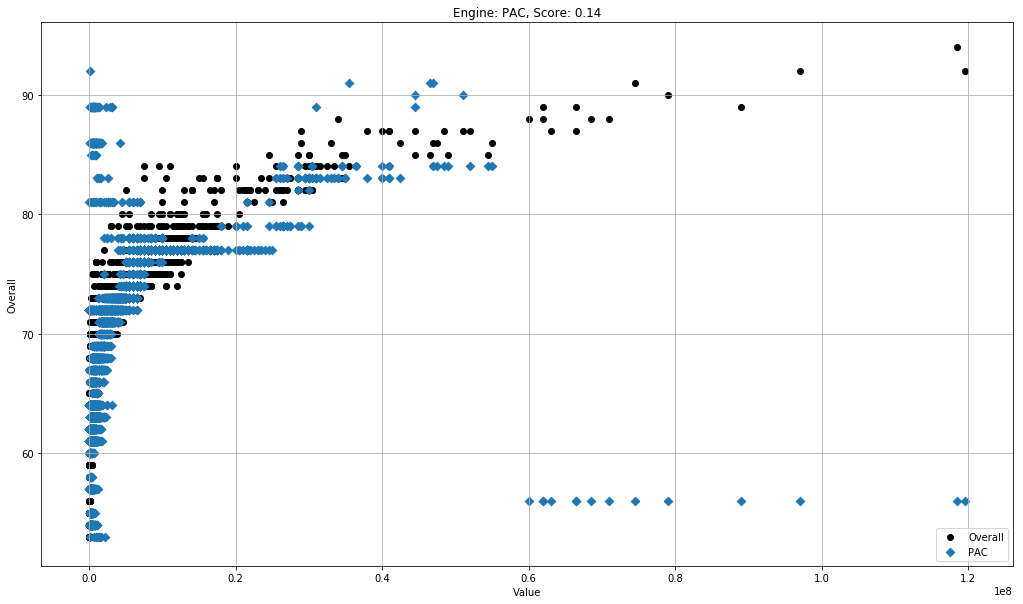

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


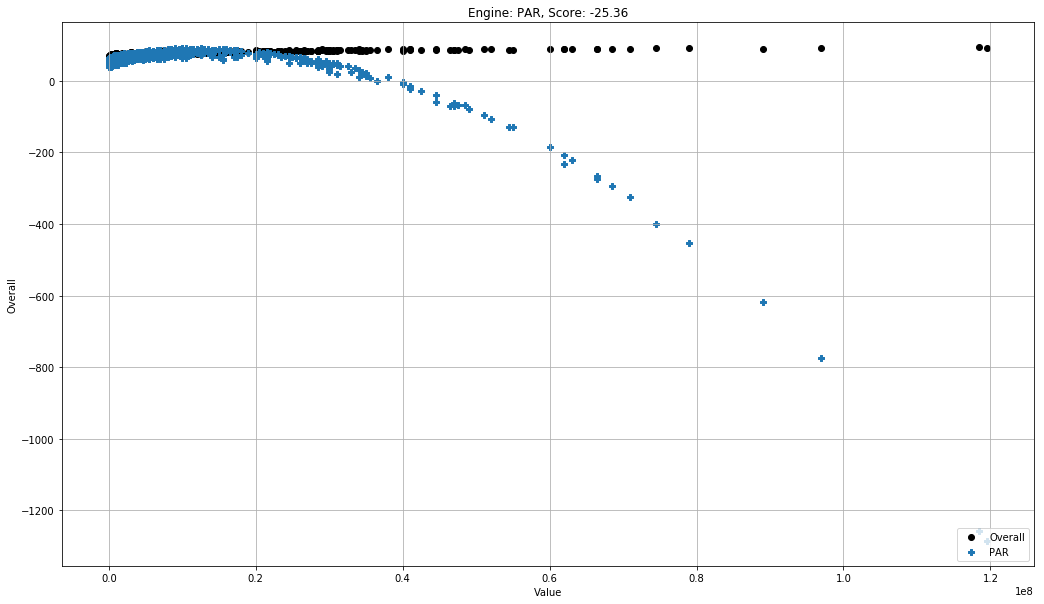

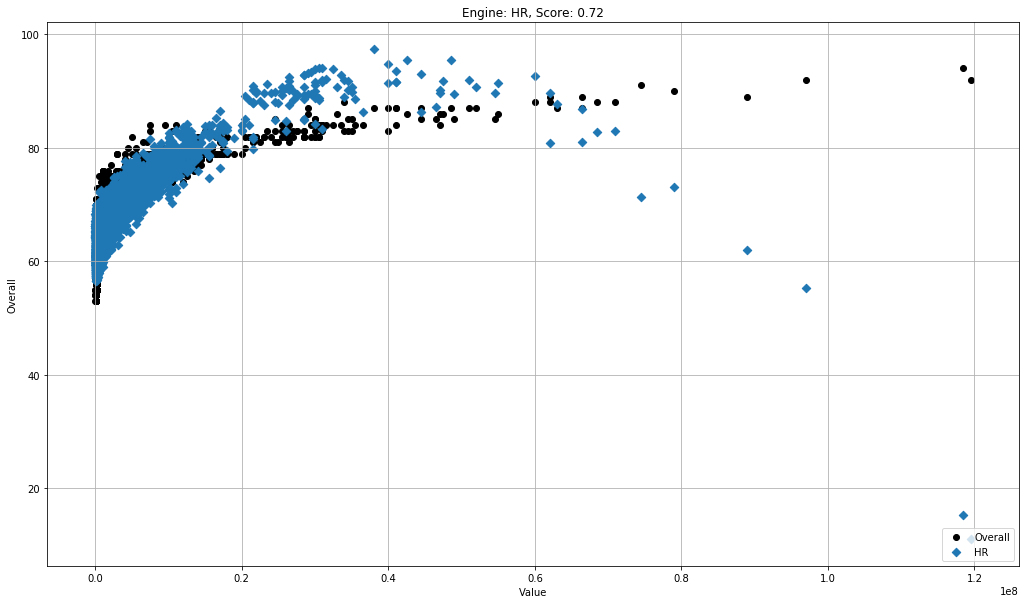

In [21]:
# Be patient this might take few minutes ;)
# Support Vector Regression - RBF (radial basis function)
# PolynomialFeatures and Ridge Regression
results  = []
ypred    = []
i        = 0
engines  = [('RBF', svm.SVR(kernel='rbf', gamma=1e-3, C=100, epsilon=0.1)),
           ('DTR', DecisionTreeRegressor()),
           ('Ridge', Ridge()),
           ('RC', RidgeClassifier()),
           ('RCCV', RidgeClassifierCV()),
           ('LR', LinearRegression(normalize=True)),
           ('PAC', PassiveAggressiveClassifier()),
           ('PAR', PassiveAggressiveRegressor()),
           ('HR', HuberRegressor(alpha=1.3, epsilon=4.4, tol=1e-4))]
for name, engine in engines:
    clf = make_pipeline(StandardScaler(), FunctionTransformer(add_squared_col), engine)
    clf.fit(xtrain, ytrain.values.ravel())
    ypred = clf.predict(xtest)
    
    results.append({"Engine": name, "Mean squared error": mean_squared_error(ytest, ypred),
         "Variance core": r2_score(ytest, ypred), "Accuracy score": clf.score(xtest, ytest),
          "predict": ypred})
    
    plt.figure(figsize=(18, 10))
    plt.scatter(xtest['ValueNum'], ytest['Overall'], linewidth=1, color='black')
    plt.scatter(xtest['ValueNum'], ypred, linewidth=1, label=name, marker=random.choice(marker))
    plt.xlabel("Value")
    plt.ylabel("Overall")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.title("Engine: {}, Score: {:.2f}".format(results[i]['Engine'], results[i]['Accuracy score']))
    #plt.text(2, 0.65, str(results[i]), fontsize=16)
    plt.subplots_adjust(left=0.15)
    plt.draw()
    plt.show()
    i += 1

>This may seem like this model is not very good, but, in this case we can accept a model that produces a few bad predictions, with the most of them being good, then this model is not as bad as we thought. That’s because the predictions seem to be pretty accurate for those players with a value lower than €30M. Although it can not be appreciated very well in the plot, those players represent 98.97% of the total!

In [22]:
pd.options.mode.chained_assignment = None

# minimum score we are willing to accept
min_score = 0.7

for result in results:
    if result['Accuracy score'] < min_score: continue
    test['Overall_{}'.format(result['Engine'])] = result['predict']
    test['Error_PCT_{}'.format(result['Engine'])] = np.abs((test.Overall - result['predict']) / test.Overall * 100)

> Update *test* DataFrame, add new columns from classifier and prediction 

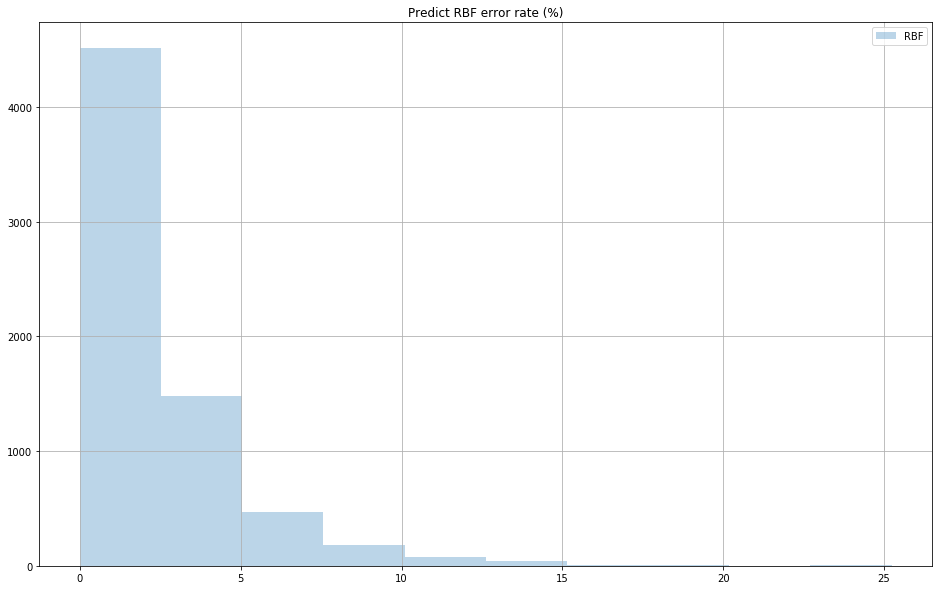

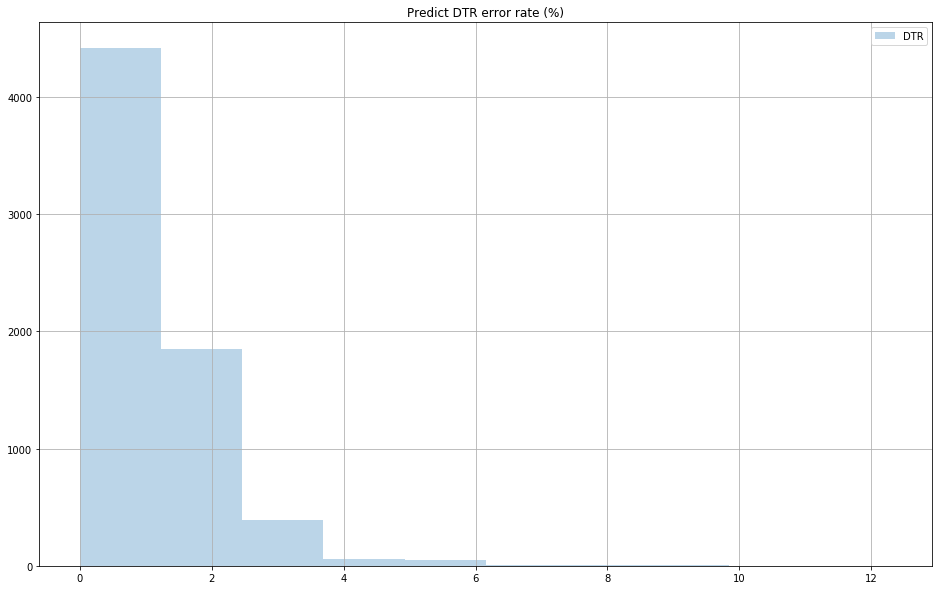

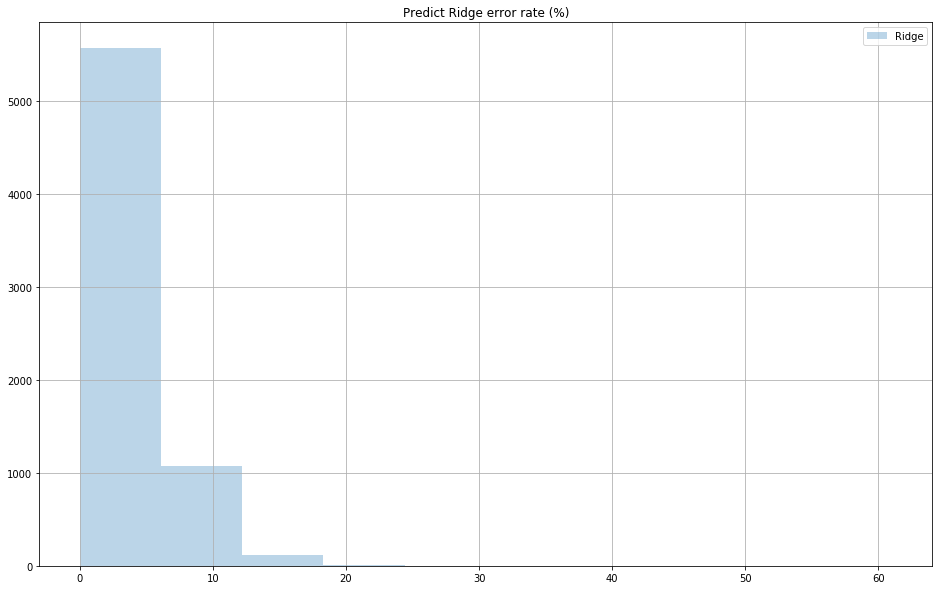

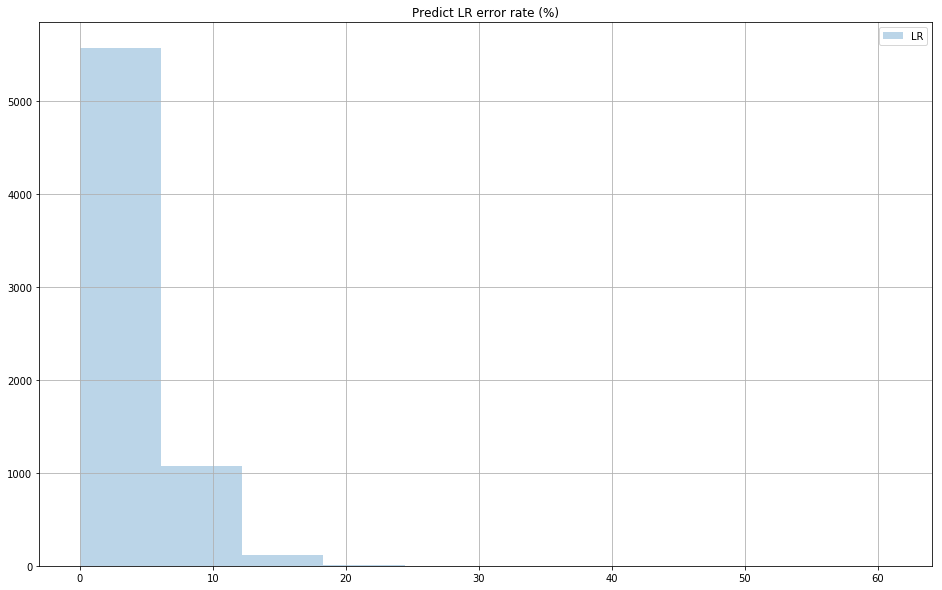

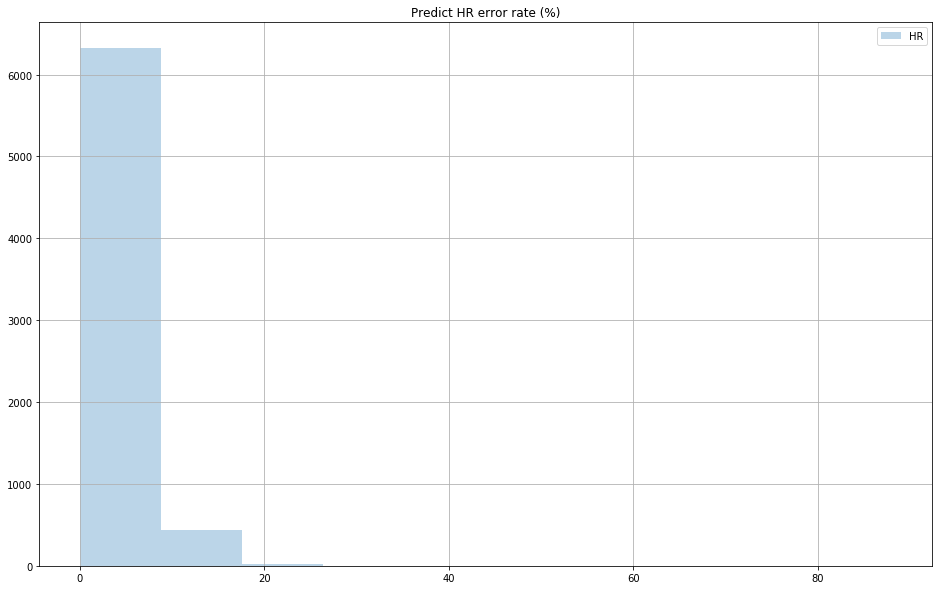

In [23]:
kwargs = dict(histtype='stepfilled', alpha=0.3)

for result in results:
    if result['Accuracy score'] < min_score: continue
    plt.figure(figsize=(16, 10))
    plt.hist(test['Error_PCT_{}'.format(result['Engine'])], **kwargs)
    plt.title("Predict {} error rate (%)".format(result['Engine']))
    plt.grid(True)
    plt.legend([result['Engine']],loc=1)
    plt.show()

>Visually, the polynomial regression looks better than the standard linear regression.

In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6780 entries, 3819 to 4007
Data columns (total 26 columns):
Name               6780 non-null object
Age                6780 non-null int64
Photo              6780 non-null object
Nationality        6780 non-null object
Overall            6780 non-null int32
Potential          6780 non-null int64
Club               6780 non-null object
Value              6780 non-null object
Wage               6780 non-null object
Aggression         6780 non-null int64
Crossing           6780 non-null int64
Dribbling          6780 non-null int64
Finishing          6780 non-null int64
Penalties          6780 non-null int64
Stamina            6780 non-null int64
ValueNum           6780 non-null float64
Overall_RBF        6780 non-null float64
Error_PCT_RBF      6780 non-null float64
Overall_DTR        6780 non-null float64
Error_PCT_DTR      6780 non-null float64
Overall_Ridge      6780 non-null float64
Error_PCT_Ridge    6780 non-null float64
Overall_LR  

> As you can see new columns *Overall_[engine]* and *Error_PCR_[engine]* have been added, populated with prediction and error percent rate

In [25]:
o = ['Overall_{}'.format(r['Engine']) for r in results if r['Accuracy score'] > min_score]
e = ['Error_PCT_{}'.format(r['Engine']) for r in results if r['Accuracy score'] > min_score]
t = ['Name', 'Club', 'Age', 'Value', 'Overall', ]
t.extend(o)
t.extend(e)
test[t].nlargest(40, columns=o+e).head(10)


,Name,Club,Age,Value,Overall,Overall_RBF,Overall_DTR,Overall_Ridge,Overall_LR,Overall_HR,Error_PCT_RBF,Error_PCT_DTR,Error_PCT_Ridge,Error_PCT_LR,Error_PCT_HR
3,L. Suárez,FC Barcelona,30,€97M,92,91.306664,91.0,70.479885,70.463316,55.299029,0.753626,1.086957,23.391429,23.409439,39.892360
14,J. Oblak,Atlético Madrid,24,€62M,89,89.571640,92.0,85.154347,85.157068,80.875512,0.642292,3.370787,4.320958,4.317901,9.128638
9,T. Kroos,Real Madrid CF,27,€79M,90,88.938321,91.0,81.938686,81.933155,73.085155,1.179644,1.111111,8.957015,8.963161,18.794272
42,P. Aubameyang,Arsenal,28,€52M,87,88.776778,86.0,93.321933,93.324455,90.711295,2.042273,1.149425,7.266589,7.269489,4.265856
65,Filipe Luís,Atlético Madrid,31,€29M,86,88.752401,84.0,93.345425,93.349531,93.279188,3.200466,2.325581,8.541192,8.545967,8.464173
45,M. Özil,Arsenal,28,€51M,87,88.558753,87.0,94.389458,94.393425,91.926854,1.791670,0.000000,8.493629,8.498189,5.663050
5,De Gea,Manchester United,26,€74.5M,91,88.394346,92.0,78.572808,78.571966,71.312657,2.863356,1.098901,13.656255,13.657181,21.634443
67,L. Sané,Manchester City,21,€54.5M,85,88.090757,88.0,92.772375,92.774210,89.596314,3.636184,3.529412,9.143971,9.146129,5.407428
53,Isco,Real Madrid CF,25,€55M,86,87.926205,87.0,94.654092,94.656977,91.378322,2.239774,1.162791,10.062898,10.066253,6.253863
32,S. Handanovič,Inter,32,€34M,88,87.696881,87.0,89.144136,89.150786,89.008483,0.344453,1.136364,1.300155,1.307711,1.146004


In [26]:
test.loc[
    (test.Age > 21) 
    & (test.Age < 27)
    & (test.ValueNum < 30000000)
#     & ((test.Error_PCT_lr < 3) & (test.Error_PCT_pirg < 3) & (test.Error_PCT_rbf < 3))
    , t ].head(10)

,Name,Club,Age,Value,Overall,Overall_RBF,Overall_DTR,Overall_Ridge,Overall_LR,Overall_HR,Error_PCT_RBF,Error_PCT_DTR,Error_PCT_Ridge,Error_PCT_LR,Error_PCT_HR
3819,P. Faragò,Cagliari,24,€3.9M,72,72.721863,72.0,70.244078,70.243940,70.308839,1.002588,0.000000,2.438781,2.438973,2.348835
1483,E. Gutiérrez,Pachuca,22,€11M,76,76.395277,76.0,75.890442,75.891973,76.237159,0.520101,0.000000,0.144156,0.142140,0.312052
7187,M. Terki,Sporting Lokeren,25,€950K,68,67.627393,68.0,68.531992,68.531967,68.366442,0.547951,0.000000,0.782341,0.782304,0.538886
7875,R. Andrich,SV Wehen Wiesbaden,22,€1.2M,67,65.807389,69.0,64.527771,64.527313,64.523254,1.780017,2.985075,3.689895,3.690578,3.696636
15448,A. Adam,Al Taawoun,22,€240K,59,60.927564,59.0,61.020493,61.019577,61.022849,3.267057,0.000000,3.424565,3.423012,3.428557
15284,J. Vivas,Club Atlético Huracán,23,€190K,59,61.332642,59.0,62.295795,62.295668,62.291781,3.953630,0.000000,5.586093,5.585878,5.579290
7531,A. Levipan,Unión Española,25,€1M,68,66.071311,68.0,65.556111,65.555580,65.509841,2.836307,0.000000,3.593954,3.594736,3.661999
7775,R. Zentner,1. FSV Mainz 05,22,€1.1M,68,64.664490,69.0,62.865245,62.864933,62.891544,4.905162,1.470588,7.551110,7.551570,7.512435
12446,A. Al Zubaidi,Al Ahli,24,€400K,63,64.449369,63.0,64.578074,64.576633,64.518797,2.300586,0.000000,2.504879,2.502591,2.410789
3088,O. Hiljemark,Genoa,25,€5M,73,74.751268,74.0,71.870843,71.871579,72.012837,2.398997,1.369863,1.546790,1.545782,1.352278
